In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Unzipping dataset .zip file into 'dataset' folder

In [2]:
cd /content

/content


In [3]:
!mkdir dataset

In [ ]:
# Takes 1-2 mins
!unzip drive/MyDrive/5554/Plant_leaf_diseases_dataset_with_augmentation.zip -d /content/dataset/

## Installing and importing required packages

In [ ]:
!pip install pyfeats

In [ ]:
!pip install mahotas

In [7]:
import os
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
import pathlib
import cv2
import random
import shutil
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import mahotas
import pyfeats
import h5py
import warnings
import pickle
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

warnings.filterwarnings('ignore')

## Getting names of all subfolders and storing them in variables for indexing and referencing purposes

In [8]:
dataset_path = "/content/dataset/Plant_leave_diseases_dataset_with_augmentation/"
folders = os.listdir(dataset_path)

dataset_index = {}

for folder in folders:
  split = folder.split("__")

  if len(split) < 2:
    continue

  leaf_type = split[0].replace(",", "")
  
  if leaf_type in dataset_index.keys():
    dataset_index[leaf_type].append(folder)
  else:
    dataset_index[leaf_type] = [folder]

dataset_index

{'Grape': ['Grape___Esca_(Black_Measles)',
  'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
  'Grape___healthy',
  'Grape___Black_rot'],
 'Corn': ['Corn___Northern_Leaf_Blight',
  'Corn___Cercospora_leaf_spot Gray_leaf_spot',
  'Corn___healthy',
  'Corn___Common_rust'],
 'Pepper_bell': ['Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy'],
 'Tomato': ['Tomato___Target_Spot',
  'Tomato___Leaf_Mold',
  'Tomato___Early_blight',
  'Tomato___Tomato_mosaic_virus',
  'Tomato___healthy',
  'Tomato___Bacterial_spot',
  'Tomato___Late_blight',
  'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
  'Tomato___Spider_mites Two-spotted_spider_mite',
  'Tomato___Septoria_leaf_spot'],
 'Soybean': ['Soybean___healthy'],
 'Strawberry': ['Strawberry___healthy', 'Strawberry___Leaf_scorch'],
 'Blueberry': ['Blueberry___healthy'],
 'Apple': ['Apple___Cedar_apple_rust',
  'Apple___healthy',
  'Apple___Black_rot',
  'Apple___Apple_scab'],
 'Peach': ['Peach___healthy', 'Peach___Bacterial_spot'],
 'Potato': ['Potat

In [9]:
classes = []

for leaf_type in dataset_index.keys():
  classes = classes + dataset_index[leaf_type]

classes

['Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Grape___Black_rot',
 'Corn___Northern_Leaf_Blight',
 'Corn___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn___healthy',
 'Corn___Common_rust',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Tomato___Target_Spot',
 'Tomato___Leaf_Mold',
 'Tomato___Early_blight',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Late_blight',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Septoria_leaf_spot',
 'Soybean___healthy',
 'Strawberry___healthy',
 'Strawberry___Leaf_scorch',
 'Blueberry___healthy',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Apple___Black_rot',
 'Apple___Apple_scab',
 'Peach___healthy',
 'Peach___Bacterial_spot',
 'Potato___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Cherry___Powdery_mildew',
 'Cherry___healthy',
 'Raspberry___healthy',
 'Or

## Creating curated dataset for classification for a specific leaf type

In [ ]:
base_path = '/content/'
curated_dataset_path = 'curated_dataset/'
class_folders = os.listdir(dataset_path)

for cls in classes:
  destination_img_base_path = base_path + curated_dataset_path + cls + '/'
  p = pathlib.Path(destination_img_base_path)
  p.mkdir(parents=True, exist_ok=True)
  source_img_paths = os.listdir(dataset_path + cls)

  for idx in tqdm(range(len(source_img_paths))):
    source_img_path = dataset_path + cls + '/' + source_img_paths[idx]
    destination_img_path = destination_img_base_path + str(idx+1) + '.jpg'
    shutil.copyfile(source_img_path, destination_img_path)

100%|██████████| 5507/5507 [00:00<00:00, 6951.03it/s]


In [ ]:
# shutil.rmtree('curated_dataset')

In [ ]:
def bgr_hsv(rgb_img):
  hsv_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)
  return hsv_img
  
#Green/Brown Segmentation
def img_segmentation(rgb_img,hsv_img):
  lower_green = np.array([25,0,20])
  upper_green = np.array([100,255,255])
  healthy_mask = cv2.inRange(hsv_img, lower_green, upper_green)
  result = cv2.bitwise_and(rgb_img,rgb_img, mask=healthy_mask)
  
  lower_brown = np.array([10,0,10])
  upper_brown = np.array([30,255,255])
  disease_mask = cv2.inRange(hsv_img, lower_brown, upper_brown)
  disease_result = cv2.bitwise_and(rgb_img, rgb_img, mask=disease_mask)
  
  final_mask = healthy_mask + disease_mask
  final_result = cv2.bitwise_and(rgb_img, rgb_img, mask=final_mask)
  
  return final_result

## Data Pre-processing

In [10]:
images_per_class = 250
fixed_size = tuple((500, 500))
mask = np.ones(fixed_size)
bins = 8

In [11]:
def bgr2rgb(image):
  rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  return rgb_img

def rgb2hsv(rgb_img):
  hsv_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)
  return hsv_img

def img_segmentation(rgb_img,hsv_img):
  l_g = np.array([25,0,20])
  u_g = np.array([100,255,255])
  h_mask = cv2.inRange(hsv_img, l_g, u_g)
  result = cv2.bitwise_and(rgb_img,rgb_img, mask=h_mask)
  
  l_b = np.array([10,0,10])
  u_b = np.array([30,255,255])
  d_mask = cv2.inRange(hsv_img, l_b, u_b)
  d_result = cv2.bitwise_and(rgb_img, rgb_img, mask=d_mask)
  
  final_mask = h_mask + d_mask
  final_result = cv2.bitwise_and(rgb_img, rgb_img, mask=final_mask)
  
  return final_result

def zernikes_moments_features(grayscale_image):
  zernikes_moments_features, labels = pyfeats.zernikes_moments(grayscale_image, radius=9)
  return zernikes_moments_features

def haralick_features(grayscale_image):
  haralick = mahotas.features.haralick(grayscale_image).mean(axis=0)
  return haralick

def histogram_features(image, mask=None):
  hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
  hist  = cv2.calcHist([hsv_image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
  cv2.normalize(hist, hist)
  return hist.flatten()

In [ ]:
train_path = base_path + curated_dataset_path

In [ ]:
for cls in classes:
  no_of_images = len(os.listdir(train_path + cls))
  print('{} : {}'.format(no_of_images, cls))

1835 : Squash___Powdery_mildew
2127 : Tomato___Bacterial_spot
1000 : Tomato___Early_blight
1676 : Tomato___Spider_mites Two-spotted_spider_mite
1771 : Tomato___Septoria_leaf_spot
1591 : Tomato___healthy
1909 : Tomato___Late_blight
1000 : Tomato___Tomato_mosaic_virus
1404 : Tomato___Target_Spot
5357 : Tomato___Tomato_Yellow_Leaf_Curl_Virus
1000 : Tomato___Leaf_Mold
1000 : Apple___Apple_scab
1000 : Apple___Black_rot
1645 : Apple___healthy
1000 : Apple___Cedar_apple_rust
1000 : Cherry___healthy
1052 : Cherry___Powdery_mildew
1000 : Raspberry___healthy
5090 : Soybean___healthy
1000 : Potato___Early_blight
1000 : Potato___healthy
1000 : Potato___Late_blight
1000 : Pepper,_bell___Bacterial_spot
1478 : Pepper,_bell___healthy
2297 : Peach___Bacterial_spot
1000 : Peach___healthy
1000 : Corn___Cercospora_leaf_spot Gray_leaf_spot
1000 : Corn___Northern_Leaf_Blight
1162 : Corn___healthy
1192 : Corn___Common_rust
1000 : Grape___healthy
1180 : Grape___Black_rot
1076 : Grape___Leaf_blight_(Isariopsis

In [ ]:
global_features = []
labels          = []

In [ ]:
for cls in classes:
  current_label = cls
  image_paths = os.listdir(train_path + cls)
  sample_set = list(range(1,len(image_paths)+1))
  sampled_image_numbers = random.sample(sample_set, images_per_class)
  sampled_image_paths = [str(sampled_image_number) + '.jpg' for sampled_image_number in sampled_image_numbers]
  print(cls)

  for idx in tqdm(range(len(sampled_image_paths))):
    image_path = sampled_image_paths[idx]
    image_bgr = cv2.imread(train_path + cls + '/' + image_path)
    image_bgr = cv2.resize(image_bgr, fixed_size)

    image_rgb = bgr2rgb(image_bgr)
    image_hsv = rgb2hsv(image_rgb)
    image_segmented = img_segmentation(image_rgb,image_hsv)
    grayscale_image = cv2.cvtColor(image_segmented, cv2.COLOR_RGB2GRAY)

    hist_features = histogram_features(image_segmented)
    zernikes_features = zernikes_moments_features(grayscale_image)
    har_features = haralick_features(grayscale_image)
    
    global_feature = np.hstack([zernikes_features,hist_features,har_features])

    labels.append(current_label)
    global_features.append(global_feature)

Peach___healthy


100%|██████████| 250/250 [00:16<00:00, 14.77it/s]


Peach___Bacterial_spot


100%|██████████| 250/250 [00:15<00:00, 16.30it/s]


Potato___healthy


100%|██████████| 250/250 [00:17<00:00, 14.47it/s]


Potato___Early_blight


100%|██████████| 250/250 [00:17<00:00, 14.10it/s]


Potato___Late_blight


100%|██████████| 250/250 [00:21<00:00, 11.78it/s]


Tomato___Spider_mites Two-spotted_spider_mite


100%|██████████| 250/250 [00:27<00:00,  9.18it/s]


Tomato___Tomato_Yellow_Leaf_Curl_Virus


100%|██████████| 250/250 [00:24<00:00, 10.32it/s]


Tomato___Late_blight


100%|██████████| 250/250 [00:27<00:00,  8.96it/s]


Tomato___Target_Spot


100%|██████████| 250/250 [00:18<00:00, 13.81it/s]


Tomato___Early_blight


100%|██████████| 250/250 [00:15<00:00, 15.69it/s]


Tomato___healthy


100%|██████████| 250/250 [00:17<00:00, 14.27it/s]


Tomato___Leaf_Mold


100%|██████████| 250/250 [00:16<00:00, 14.95it/s]


Tomato___Septoria_leaf_spot


100%|██████████| 250/250 [00:16<00:00, 14.94it/s]


Tomato___Tomato_mosaic_virus


100%|██████████| 250/250 [00:15<00:00, 15.64it/s]


Tomato___Bacterial_spot


100%|██████████| 250/250 [00:14<00:00, 16.86it/s]


Blueberry___healthy


100%|██████████| 250/250 [00:20<00:00, 12.17it/s]


Corn___Cercospora_leaf_spot Gray_leaf_spot


100%|██████████| 250/250 [00:16<00:00, 14.75it/s]


Corn___healthy


100%|██████████| 250/250 [00:17<00:00, 14.59it/s]


Corn___Northern_Leaf_Blight


100%|██████████| 250/250 [00:21<00:00, 11.81it/s]


Corn___Common_rust


100%|██████████| 250/250 [00:17<00:00, 14.15it/s]


Apple___Apple_scab


100%|██████████| 250/250 [00:23<00:00, 10.73it/s]


Apple___healthy


100%|██████████| 250/250 [00:15<00:00, 15.69it/s]


Apple___Black_rot


100%|██████████| 250/250 [00:17<00:00, 14.38it/s]


Apple___Cedar_apple_rust


100%|██████████| 250/250 [00:16<00:00, 15.38it/s]


Raspberry___healthy


100%|██████████| 250/250 [00:16<00:00, 14.85it/s]


Strawberry___healthy


100%|██████████| 250/250 [00:18<00:00, 13.20it/s]


Strawberry___Leaf_scorch


100%|██████████| 250/250 [00:23<00:00, 10.56it/s]


Squash___Powdery_mildew


100%|██████████| 250/250 [00:22<00:00, 11.00it/s]


Pepper,_bell___Bacterial_spot


100%|██████████| 250/250 [00:27<00:00,  9.18it/s]


Pepper,_bell___healthy


100%|██████████| 250/250 [00:17<00:00, 14.13it/s]


Grape___Leaf_blight_(Isariopsis_Leaf_Spot)


100%|██████████| 250/250 [00:16<00:00, 15.19it/s]


Grape___healthy


100%|██████████| 250/250 [00:16<00:00, 15.20it/s]


Grape___Black_rot


100%|██████████| 250/250 [00:16<00:00, 14.75it/s]


Grape___Esca_(Black_Measles)


100%|██████████| 250/250 [00:18<00:00, 13.36it/s]


Orange___Haunglongbing_(Citrus_greening)


100%|██████████| 250/250 [00:14<00:00, 17.07it/s]


Cherry___healthy


100%|██████████| 250/250 [00:17<00:00, 14.68it/s]


Cherry___Powdery_mildew


100%|██████████| 250/250 [00:18<00:00, 13.39it/s]


Soybean___healthy


100%|██████████| 250/250 [00:17<00:00, 14.10it/s]


## Save Global Features and Labels in Pickle file

In [ ]:
properties =  'imsize='+str(fixed_size[0]) +'x'+str(fixed_size[0]) + \
              '_'+'perclsimgs=' + str(images_per_class) + \
              '_clsnum=' + str(len(classes))

In [ ]:
global_features_filename = 'globalfeatures' + '_' + properties + '.pkl'
labels_filename = 'labels' + '_' + properties + '.pkl'

print('Global Features save filename: {}'.format(global_features_filename))
print('Labels save filename: {}'.format(global_features_filename))

Global Features save filename: globalfeatures_imsize=500x500_perclsimgs=10000_clsnum=2.pkl
Labels save filename: globalfeatures_imsize=500x500_perclsimgs=10000_clsnum=2.pkl


In [ ]:
with open(global_features_filename, 'wb') as fp:
  pickle.dump(global_features, fp)

with open(labels_filename, 'wb') as fp:
  pickle.dump(labels, fp)

Code for saving onto Google Drive

In [ ]:
shutil.copy(global_features_filename,'/content/drive/MyDrive/5554')
shutil.copy(labels_filename,'/content/drive/MyDrive/5554')

'/content/drive/MyDrive/5554/labels_imsize=500x500_perclsimgs=10000_clsnum=2.pkl'

Code for loading the model


In [12]:
saved_gf_path = '/content/drive/MyDrive/5554/globalfeatures_imsize=500x500_perclsimgs=800_clsnum=38.pkl'
saved_label_path = '/content/drive/MyDrive/5554/labels_imsize=500x500_perclsimgs=800_clsnum=38.pkl'

with open(saved_gf_path, 'rb') as file:
  global_features = pickle.load(file)

with open(saved_label_path, 'rb') as file:
  labels = pickle.load(file)

Lengths of Vectors

In [13]:
print('Feature Vector shape: {}'.format(np.array(global_features).shape))
print('Training Labels shape: {}'.format(np.array(labels).shape))

Feature Vector shape: (30400, 550)
Training Labels shape: (30400,)


## Standardizing input data and Training XGBoost

In [14]:
label_names = np.unique(labels)
labelencoder = LabelEncoder()
labels_enc = labelencoder.fit_transform(labels)

In [15]:
print('Encoded Labels: {}'.format(labels_enc))
print('Encoded Labels shape: {}'.format(labels_enc.shape))

Encoded Labels: [17 17 17 ... 24 24 24]
Encoded Labels shape: (30400,)


In [16]:
X_train, X_test, y_train, y_test = train_test_split(np.array(global_features), labels_enc, test_size=.3)

In [17]:
print('Train Shape: {}'.format(X_train.shape))
print('Test Shape: {}'.format(X_test.shape))

Train Shape: (21280, 550)
Test Shape: (9120, 550)


In [ ]:
xgb_clf = XGBClassifier(max_depth=3, verbosity=1)

In [ ]:
xgb_clf.fit(X_train, y_train)

XGBClassifier(objective='multi:softprob')

In [ ]:
predictions = xgb_clf.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_test,predictions)
print('Accuracy: {}'.format(acc))

Accuracy: 0.8900219298245614


## Save XGBoost model


In [ ]:
model_filename = 'xgboost_' + properties + '_tstacc=%.2f'% acc + '.pkl'
print('Filename for saving xgboost model: {}'.format(model_filename))

Filename for saving xgboost model: xgboost_imsize=500x500_perclsimgs=250_clsnum=38_tstacc=0.89.pkl


In [ ]:
# save xgboost model

with open(model_filename, 'wb') as fp:
  pickle.dump(xgb_clf, fp)

In [ ]:
shutil.copy(model_filename,'/content/drive/MyDrive/5554')

'/content/drive/MyDrive/5554/xgboost_imsize=500x500_perclsimgs=250_clsnum=38_tstacc=0.89.pkl'

## Load XGBoost model for evaluation on data

In [ ]:
model_filename = '/content/drive/MyDrive/5554/xgboost_imsize=500x500_perclsimgs=800_clsnum=38_tstacc=0.89.pkl'

In [ ]:
with open(model_filename, 'rb') as fp:
  testclf = pickle.load(fp)

In [ ]:
def random_prediction():
  dataset_path = '/content/dataset/Plant_leave_diseases_dataset_with_augmentation/'
  sample_folder_name = random.choice(os.listdir(dataset_path))
  sample_folder_path = dataset_path + sample_folder_name + "/"

  sample_image_name = random.choice(os.listdir(sample_folder_path))
  sample_image_path = sample_folder_path + sample_image_name

  image_bgr = cv2.imread(sample_image_path)
  image_rgb = bgr2rgb(image_bgr)
  image_hsv = rgb2hsv(image_rgb)
  image_segmented = img_segmentation(image_rgb,image_hsv)
  grayscale_image = cv2.cvtColor(image_segmented, cv2.COLOR_RGB2GRAY)

  hist_features = histogram_features(image_segmented)
  zernikes_features = zernikes_moments_features(grayscale_image)
  har_features = haralick_features(grayscale_image)
  
  global_feature = np.hstack([zernikes_features,hist_features,har_features])

  plt.title(sample_folder_name + '/' + sample_image_name)
  plt.imshow(image_rgb)
  plt.show()

  predicted_index = testclf.predict(np.reshape(global_feature,(1,len(global_feature))))
  
  prediction = np.unique(classes)[predicted_index]
  print("Prediction : {}".format(prediction))

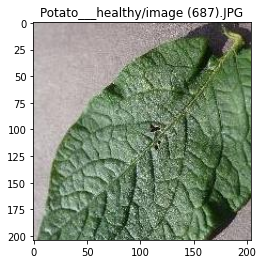

Prediction : ['Potato___healthy']


In [ ]:
random_prediction()